# **Clustering con KMeans + RandomForest**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid, learning_curve
import matplotlib.pyplot as plt

## **Descarga del Dataset original**

Para descargar el dataset a Colab, es necesario subir su Kaggle API Key personal (para crear una nueva, revise la sección Authentication en https://www.kaggle.com/docs/api).

Suba a continuación el archivo `.json` generado.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daniellujanagudelo","key":"e0f7fc0287fd836756e720097ec0469f"}'}

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

 96% 663M/688M [00:03<00:00, 233MB/s]
100% 688M/688M [00:03<00:00, 198MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/home-credit-default-risk.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## **Preprocesamiento**

La siguiente función realiza todo el preprocesamiento necesario a los datos, explicado en [01 - Preprocesamiento.ipynb](https://colab.research.google.com/drive/1w9a0auNVqZ2hN_urrf3rmJ-3gVfDUBx0#scrollTo=2c5ymp78xowc)

In [ ]:
def preprocess_data(data: pd.DataFrame, test_data: pd.DataFrame):
    def fill_nan_with_mode(column):
        mode = column.mode()[0]
        return column.fillna(mode)
    data = data.fillna(data.mean()).apply(fill_nan_with_mode, axis=0)
    test_data = test_data.fillna(test_data.mean()).apply(fill_nan_with_mode, axis=0)
    cat_columns = data.select_dtypes(include=["object"])
    data_encoded = pd.get_dummies(data, columns=cat_columns.columns)
    test_data_encoded = pd.get_dummies(test_data, columns=cat_columns.columns)

    return data_encoded, test_data_encoded

data, test_data = preprocess_data(pd.read_csv("/content/application_train.csv"), pd.read_csv("/content/application_test.csv"))

<ipython-input-7-c319868e6578>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean()).apply(fill_nan_with_mode, axis=0)
<ipython-input-7-c319868e6578>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data = test_data.fillna(test_data.mean()).apply(fill_nan_with_mode, axis=0)


In [ ]:
X_train = data.drop("TARGET", axis=1)
y_train = data["TARGET"]
for col in X_train.columns.difference(test_data.columns):
    test_data[col] = [0] * len(test_data)

test_data = test_data[X_train.columns]

## **Clustering**

### **Mejores hiperparámetros para KMeans**

In [ ]:
param_grid = {'n_clusters': [6, 12, 20]}

results = []

for params in ParameterGrid(param_grid):
    kmeans = KMeans(**params)
    kmeans.fit(X_train)

    score = silhouette_score(X_train, kmeans.labels_)

    results.append({'params': params, 'score': score})

best_params = max(results, key=lambda x: x['score'])['params']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
best_params

{'n_clusters': 6}

### **Clustering con el mejor número de clusters**

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)

kmeans.fit(X_train)
train_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)

kmeans.fit(test_data)
test_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Ahora, vamos a añadir una nueva columna con el número de cluster al que pertenece cada registro en el dataset.

In [ ]:
X_train["cluster_number"] = train_labels
test_data["cluster_number"] = test_labels

## **Predicción con RandomForestClassifier**

Luego, entrenamos el modelo con el nuevo dataset

> Se usaron los mejores hiperparámetros para RandomForestClassifier obtenidos en [02 - Modelo con Random Forest.ipynb](https://colab.research.google.com/drive/1ZFj3-y84ePRhsnzHP2dSzKhrRsDT0vCz#scrollTo=y9CB8LWRmPvg)

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [ ]:
y_pred = model.predict_proba(test_data)

In [ ]:
df = pd.DataFrame()
df["SK_ID_CURR"] = test_data["SK_ID_CURR"]
df["TARGET"] = y_pred[:, 1]
df = df.set_index("SK_ID_CURR")
df.to_csv("results.csv")

## **Resultados**

Usando clustering con KMeans y un modelo de RandomForest, se obtuvieron los siguientes resultados:

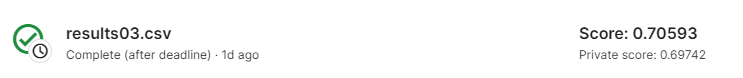

## **Curva de Aprendizaje**

## **Curva de aprendizaje**

In [ ]:
res = learning_curve(
    model, X_train, y_train, cv=4, n_jobs=-1, train_sizes=[0.1, 0.35, 0.6, 1.0]
)

In [ ]:
train_sizes = res[0]
train_scores = res[1]
test_scores = res[2]

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

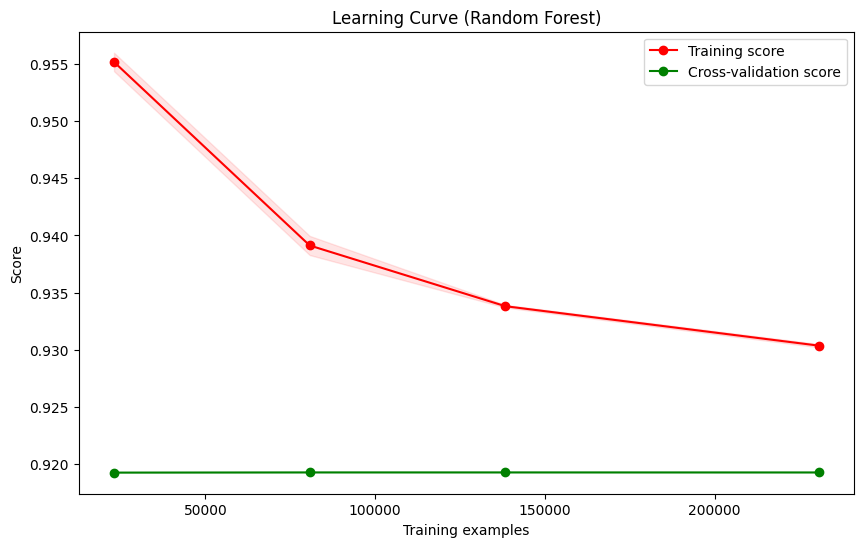

In [ ]:
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (KMeans + Random Forest)")
plt.show()